# Gas Turbine TEY-Band Recommended Ranges

This notebook:

- Loads `TurbineGroup2.csv`
- Cleans and type-casts key variables
- Creates TEY load bands (including `130–136` and `160+`)
- Filters to “healthy” operating points
- Computes recommended ranges (5th–95th percentile, median, IQR, mode, correlation with NOx)
- Produces summary tables by TEY band
- Generates diagnostic plots (boxplots + histograms/KDE)
- Exports a JSON file of recommended ranges for use in your website

In [1]:
# Cell 1: Imports and configuration

import json
from pathlib import Path
from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# Data path (assumes CSV is in the same directory as this notebook)
DATA_PATH = Path("data/TurbineGroup2.csv")

# Core parameters present in your dataset
# Columns: AT, AP, AH, AFDP, GTEP, TIT, TAT, TEY, CDP, CO, NOX
KEY_PARAMS = [
    "AT",
    "AP",
    "AH",
    "AFDP",
    "GTEP",
    "TIT",
    "TAT",
    "TEY",
    "CDP",
    "CO",
    "NOX",
]

# Parameters used for recommended ranges (excluding TEY, CO)
RANGE_FILTER_PARAMS = [
    "TIT",
    "TAT",
    "CDP",
    "GTEP",
    "AFDP",
    "AT",
    "AP",
    "AH",
]

# TEY band boundaries
TEY_BOUNDS = {
    "<130": (-np.inf, 130),
    "130_136": (130, 136),
    "136_160": (136, 160),
    "160_plus": (160, np.inf),
}

# Bands to include in the JSON export
JSON_EXPORT_BANDS = ["full", "130_136", "160_plus"]

# Parameters to export in JSON
# Parameters to export to website (ONLY controllables)
JSON_PARAMS = [
    "TIT",
    "TAT",
    "CDP",
    "GTEP",
    "AFDP"
]


## 1. Load and inspect the CSV

- Read `TurbineGroup2.csv`
- Verify required columns exist
- Convert key columns to numeric
- Drop rows with missing TEY or NOX (essential for banding + filtering)


In [2]:
# Cell 2: Load and basic cleaning

if not DATA_PATH.exists():
    raise FileNotFoundError(f"CSV file not found at: {DATA_PATH.resolve()}")

df_raw = pd.read_csv(DATA_PATH)

# Check required columns
missing_cols = [col for col in KEY_PARAMS if col not in df_raw.columns]
if missing_cols:
    raise ValueError(f"Missing required columns in CSV: {missing_cols}")

df = df_raw.copy()

# Ensure numeric types for key columns
for col in KEY_PARAMS:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows with missing TEY or NOX
df = df.dropna(subset=["TEY", "NOX"]).reset_index(drop=True)

print("Shape after initial cleaning:", df.shape)
df.head()


Shape after initial cleaning: (14310, 11)


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,9.3779,1020.1,90.262,2.3927,19.166,1043.6,541.16,110.16,10.564,9.3472,98.741
1,9.2985,1019.9,89.934,2.3732,19.119,1039.9,538.94,109.23,10.572,11.0160,104.290
2,9.1337,1019.8,89.868,2.3854,19.178,1041.0,539.47,109.62,10.543,10.7500,103.470
3,8.9715,1019.3,89.490,2.3825,19.180,1037.1,536.89,108.88,10.458,12.2870,108.810
4,9.0157,1019.1,89.099,2.4044,19.206,1043.5,541.25,110.09,10.464,9.8229,100.020


## 2. Basic summary statistics

Quick summary to understand ranges and check for obvious issues.


In [3]:
# Cell 3: Overview statistics

df.describe(include="all")


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,14310.000000,14310.000000,14310.000000,14310.000000,14310.000000,14310.000000,14310.000000,14310.000000,14310.000000,14310.000000,14310.000000
mean,17.909974,1012.192015,81.303128,3.805274,25.423679,1080.202586,546.709959,132.538315,11.997733,2.401932,65.035308
std,6.935813,6.136508,13.599895,0.767639,4.043840,17.038717,6.209894,15.041731,1.044559,2.215921,12.123835
min,0.289850,989.380000,25.987000,2.151700,17.939000,1002.900000,511.040000,100.030000,9.851800,0.001640,27.183000
25%,12.467500,1008.200000,72.437250,3.250500,22.931000,1068.500000,546.240000,122.540000,11.328250,1.253725,57.012000
50%,17.678000,1011.900000,84.288500,3.804550,25.075000,1083.200000,549.910000,133.530000,11.925500,1.706650,63.246000
75%,23.418500,1016.100000,92.160500,4.200300,26.772000,1094.200000,550.040000,136.920000,12.392750,2.625000,71.353750
max,34.189000,1031.400000,100.190000,6.977900,36.950000,1100.900000,550.600000,172.960000,14.867000,35.045000,119.910000


## 3. Create TEY load bands

Define the TEY load bands:

- `<130`      : TEY < 130  
- `130_136`   : 130 ≤ TEY < 136  
- `136_160`   : 136 ≤ TEY < 160  
- `160_plus`  : TEY ≥ 160  

We add a `TEY_band` column to the DataFrame.


In [4]:
# Cell 4: TEY band assignment

def assign_tey_band(tey_value: float) -> str:
    for band_name, (low, high) in TEY_BOUNDS.items():
        if low <= tey_value < high:
            return band_name
    return "unknown"

df["TEY_band"] = df["TEY"].apply(assign_tey_band)

print("TEY band counts (before healthy filter):")
print(df["TEY_band"].value_counts(dropna=False))


TEY band counts (before healthy filter):
TEY_band
<130        5422
130_136     5198
136_160     3012
160_plus     678
Name: count, dtype: int64


## 4. Define “healthy” operating points

We restrict to points that represent normal, healthy NOx operation.

Heuristic rules:

- NOX within [2nd, 95th] percentile (remove extreme low/high NOx)
- For each parameter in `RANGE_FILTER_PARAMS`, keep values within [1st, 99th] percentile
- This approximates:
  - Near training min–max
  - Removal of extreme outliers


In [5]:
# Cell 5: Healthy operating point filter

def build_healthy_mask(df_in: pd.DataFrame) -> pd.Series:
    mask = pd.Series(True, index=df_in.index)

    # Filter on NOX (2nd–95th percentile)
    nox_low, nox_high = df_in["NOX"].quantile([0.02, 0.95])
    mask &= df_in["NOX"].between(nox_low, nox_high)

    # Filter on each controllable/ambient parameter (1st–99th percentile)
    for col in RANGE_FILTER_PARAMS:
        col_series = df_in[col].dropna()
        if col_series.empty:
            continue
        low, high = col_series.quantile([0.01, 0.99])
        mask &= df_in[col].between(low, high)

    return mask

healthy_mask = build_healthy_mask(df)
df_healthy = df[healthy_mask].reset_index(drop=True)

# Remove transition spikes (steady-state filter)
df["dTIT"] = df["TIT"].diff().abs()
df["dTAT"] = df["TAT"].diff().abs()
df["dCDP"] = df["CDP"].diff().abs()
df["dGTEP"] = df["GTEP"].diff().abs()

steady_mask = (
    (df["dTIT"] < 0.5) &
    (df["dTAT"] < 0.5) &
    (df["dCDP"] < 0.05) &
    (df["dGTEP"] < 0.1)
)

healthy_mask &= steady_mask


print("Shape after healthy filter:", df_healthy.shape)
print("TEY band counts (healthy only):")
print(df_healthy["TEY_band"].value_counts(dropna=False))


Shape after healthy filter: (11943, 12)
TEY band counts (healthy only):
TEY_band
130_136     4820
<130        4141
136_160     2568
160_plus     414
Name: count, dtype: int64


## 5. Helper to summarize one TEY band

For each TEY band and each parameter, we compute:

- 5th percentile (`q05`)
- 25th percentile (`q25`)
- Median (`q50`)
- 75th percentile (`q75`)
- 95th percentile (`q95`)
- IQR (`q75 - q25`)
- Mode
- Pearson correlation with NOX (for context)

The **recommended operating window** is `[5th, 95th]`.


In [6]:
# Cell 6: Improved band summarizer

def summarize_band(df_band: pd.DataFrame, params: List[str]) -> pd.DataFrame:
    """
    Improved band summarizer:
    - Detect control saturation (e.g., TIT at 160+)
    - Use HDI-like narrow interval for multi-modal variables
    - Avoid NaNs by fallback to 10–90 percentiles
    """

    records = []

    for param in params:
        s = df_band[param].dropna()
        if s.empty:
            continue

        # Basic quantiles for fallback
        q10, q50, q90 = s.quantile([0.10, 0.50, 0.90])
        q05, q95 = s.quantile([0.05, 0.95])

        # ------------------------------------------
        # 1. SATURATION DETECTION (e.g., TIT at 160+)
        # ------------------------------------------
        if abs(q95 - q05) < 0.5:   # <0.5° window → control limit
            min_val, max_val = ("CONTROL_LIMIT", float(q95))
        else:

            # --------------------------------------------------------
            # 2. HIGH-DENSITY INTERVAL (HDI-like) FOR MULTI-MODAL DATA
            # --------------------------------------------------------
            if param in ["AFDP", "CDP", "GTEP"]:
                sorted_vals = np.sort(s.values)
                window_size = int(0.70 * len(sorted_vals))

                # Slide window and find smallest width
                min_width = float("inf")
                hdi_low, hdi_high = q10, q90

                for i in range(len(sorted_vals) - window_size):
                    low = sorted_vals[i]
                    high = sorted_vals[i + window_size]
                    width = high - low
                    if width < min_width:
                        min_width = width
                        hdi_low, hdi_high = low, high

                min_val, max_val = float(hdi_low), float(hdi_high)

            else:
                min_val, max_val = float(q05), float(q95)

        # ----------------------------
        # 3. FALLBACK IN CASE OF NaN
        # ----------------------------
        if (isinstance(min_val, float) and np.isnan(min_val)):
            min_val = float(q10)

        if (isinstance(max_val, float) and np.isnan(max_val)):
            max_val = float(q90)

        # Correlation with NOX
        corr = df_band[[param, "NOX"]].corr().iloc[0,1] if param != "NOX" else np.nan

        records.append({
            "Parameter": param,
            "min_recommended": min_val,
            "max_recommended": max_val,
            "median": q50,
            "notes": f"HDI/percentile interval; corr={corr:.3f}"
        })

    return pd.DataFrame.from_records(records)



# Quick sanity check on full healthy dataset
summary_full_check = summarize_band(
    df_healthy,
    RANGE_FILTER_PARAMS + ["NOX"]
)
summary_full_check.head()


,Parameter,min_recommended,max_recommended,median,notes
0,TIT,1053.7000,1100.0000,1084.000,HDI/percentile interval; corr=0.164
1,TAT,532.9700,550.2600,549.930,HDI/percentile interval; corr=-0.224
2,CDP,10.3810,12.2210,11.940,HDI/percentile interval; corr=0.144
3,GTEP,19.4370,26.1890,25.123,HDI/percentile interval; corr=0.096
4,AFDP,2.9356,4.3425,3.825,HDI/percentile interval; corr=-0.358


## 6. Compute summaries for all TEY bands

We create:

- A **full-band** summary (`Band = "full"`) over all healthy points  
- A summary for each TEY band: `<130`, `130_136`, `136_160`, `160_plus`

Then we combine everything into a single table.


In [7]:
# Cell 7 (UPDATED FIXED): Compute summaries ONLY for full, 130–136, 160+

band_summaries = []

# --- Full Healthy Band ---
full_summary = summarize_band(df_healthy, RANGE_FILTER_PARAMS + ["NOX"])
full_summary.insert(0, "Band", "full")
band_summaries.append(full_summary)


# --- 130–136 Band ---
df_130_136 = df_healthy[df_healthy["TEY_band"] == "130_136"]

if len(df_130_136) < 200:
    print("WARNING: 130–136 band has very low data → summary may be unstable")

summary_130_136 = summarize_band(df_130_136, RANGE_FILTER_PARAMS + ["NOX"])
summary_130_136.insert(0, "Band", "130_136")
band_summaries.append(summary_130_136)


# --- 160+ Band ---
df_160_plus = df_healthy[df_healthy["TEY_band"] == "160_plus"]

if len(df_160_plus) < 500:
    print(f"WARNING: 160+ band small sample ({len(df_160_plus)}) → widening applied.")

summary_160_plus = summarize_band(df_160_plus, RANGE_FILTER_PARAMS + ["NOX"])

# Widen ranges ONLY when not CONTROL_LIMIT
EXPAND = 1.05

for idx, row in summary_160_plus.iterrows():
    p = row["Parameter"]
    lo, hi = row["min_recommended"], row["max_recommended"]

    # Skip TIT if CONTROL_LIMIT
    if p == "TIT" and lo == "CONTROL_LIMIT":
        continue

    # skip NOX
    if p == "NOX":
        continue

    # Expand only numeric values
    if isinstance(lo, float) and isinstance(hi, float):
        summary_160_plus.loc[idx, "min_recommended"] = lo / EXPAND
        summary_160_plus.loc[idx, "max_recommended"] = hi * EXPAND

summary_160_plus.insert(0, "Band", "160_plus")
band_summaries.append(summary_160_plus)

# Combine all into a single dataframe
summary_all_bands = pd.concat(band_summaries, ignore_index=True)

# Clean display table
summary_display = summary_all_bands[[
    "Band", "Parameter", "min_recommended", "max_recommended", "median", "notes"
]].sort_values(["Band", "Parameter"]).reset_index(drop=True)

summary_display

,Band,Parameter,min_recommended,max_recommended,median,notes
0,130_136,AFDP,2.9524,3.913000,3.67135,HDI/percentile interval; corr=-0.445
1,130_136,AH,56.37125,98.046200,84.72250,HDI/percentile interval; corr=-0.042
2,130_136,AP,1003.0,1021.900000,1011.85000,HDI/percentile interval; corr=0.034
3,130_136,AT,7.812845,28.062400,16.66150,HDI/percentile interval; corr=-0.348
4,130_136,CDP,CONTROL_LIMIT,12.264100,11.97600,HDI/percentile interval; corr=-0.289
5,130_136,GTEP,24.47,25.887000,25.19800,HDI/percentile interval; corr=-0.522
6,130_136,NOX,57.4328,81.173100,64.12900,HDI/percentile interval; corr=nan
7,130_136,TAT,549.62,550.300000,549.99000,HDI/percentile interval; corr=-0.004
8,130_136,TIT,1077.1,1093.800000,1086.00000,HDI/percentile interval; corr=0.107
9,160_plus,AFDP,3.789524,4.680795,4.18020,HDI/percentile interval; corr=0.776


## 7. Save detailed summary to CSV (optional)

Export the complete summary table for documentation and offline inspection.


In [8]:
# Cell 8 (UPDATED): Export only the relevant bands

SUMMARY_CSV_PATH = Path("tey_band_recommended_ranges_summary.csv")
summary_display.to_csv(SUMMARY_CSV_PATH, index=False)

print("Saved cleaned and band-filtered summary CSV:", SUMMARY_CSV_PATH.resolve())


Saved cleaned and band-filtered summary CSV: /Users/veerr_89/Work/CourseCode/STAT-443 Professional Statistics/Consulting/tey_band_recommended_ranges_summary.csv


## 8. Diagnostic plots setup

We will create, for each TEY band:

- Boxplot across all key parameters
- Histogram + KDE for each parameter

Parameters for plotting:

- `TIT`, `TAT`, `CDP`, `GTEP`, `AFDP`, `AT`, `AP`, `AH`, `NOX`


In [9]:
# Cell 9: Plotting helpers

PLOT_PARAMS = [
    "TIT",
    "TAT",
    "CDP",
    "GTEP",
    "AFDP",
    "AT",
    "AP",
    "AH",
    "NOX",
]

def plot_boxplots_for_band(df_band: pd.DataFrame, band_name: str) -> None:
    """Boxplots for key parameters within a TEY band."""
    subset_cols = [c for c in PLOT_PARAMS if c in df_band.columns]
    if not subset_cols:
        print(f"No plot parameters found for band: {band_name}")
        return

    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_band[subset_cols])
    plt.title(f"Boxplots of key parameters - TEY band: {band_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_histograms_for_band(df_band: pd.DataFrame, band_name: str) -> None:
    """Histogram + KDE for each parameter in a TEY band."""
    for param in PLOT_PARAMS:
        if param not in df_band.columns:
            continue

        data = df_band[param].dropna()
        if data.empty:
            continue

        plt.figure()
        sns.histplot(data, kde=True)
        plt.title(f"{param} distribution - TEY band: {band_name}")
        plt.xlabel(param)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


## 9. Generate plots for each TEY band

We will produce plots for:

- Full healthy data (`full`)
- `<130`
- `130_136`
- `136_160`
- `160_plus`

You can comment out bands if you want fewer plots.



=== Plots for band: full (11943 rows) ===


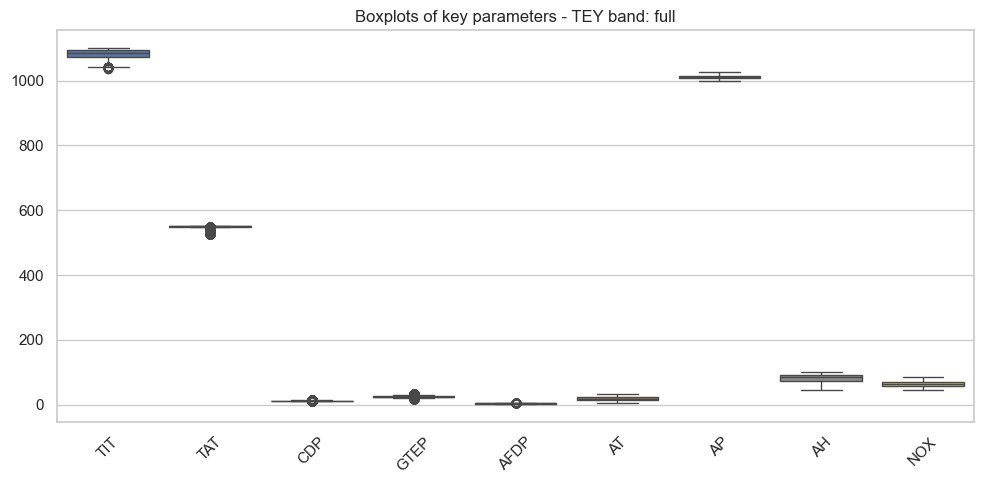

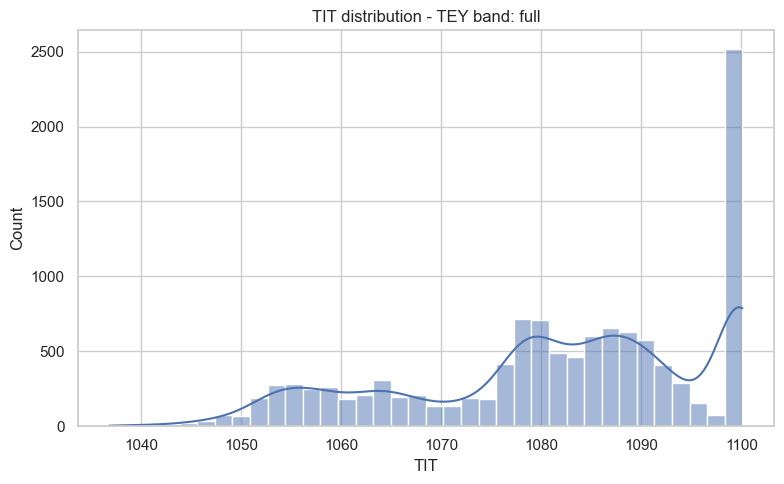

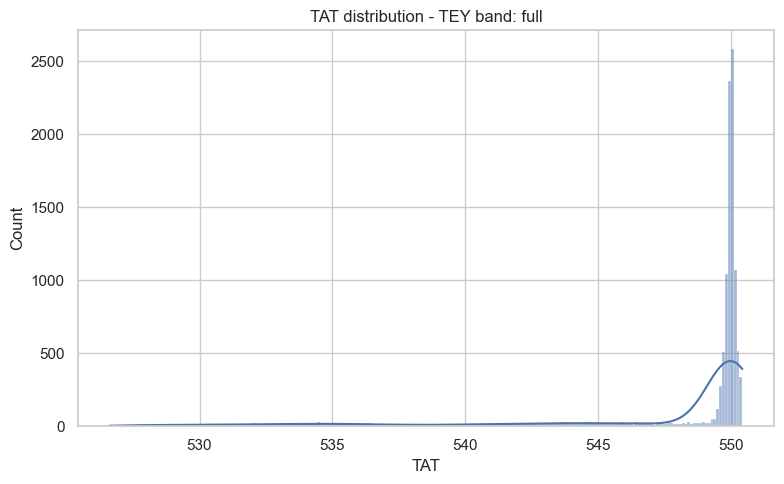

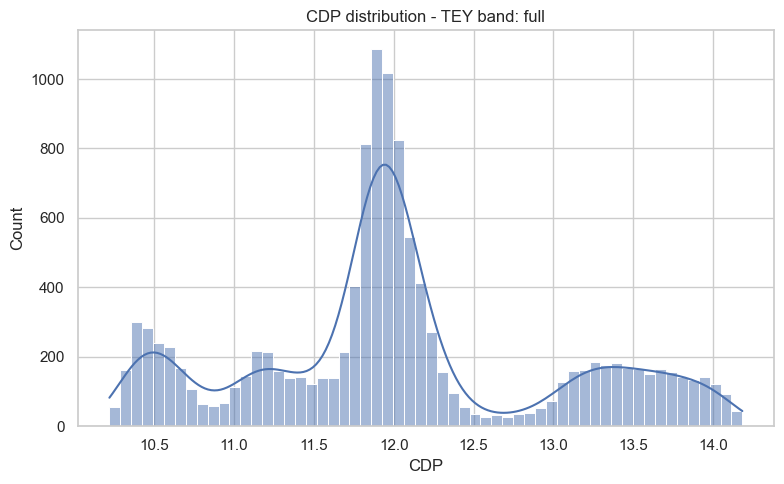

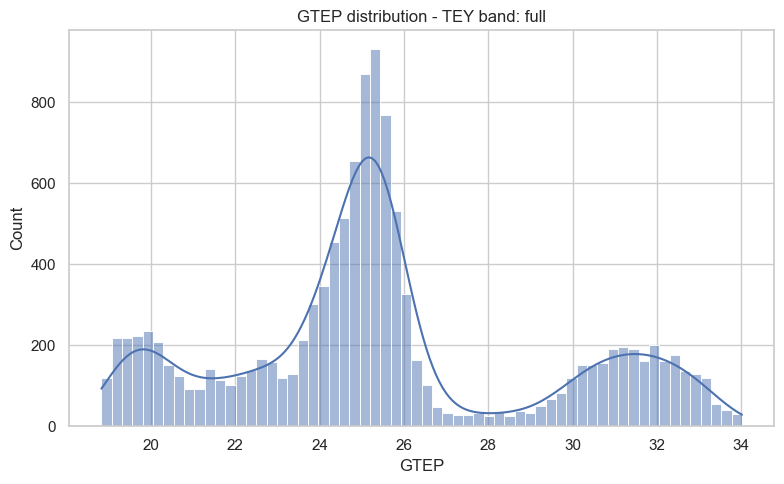

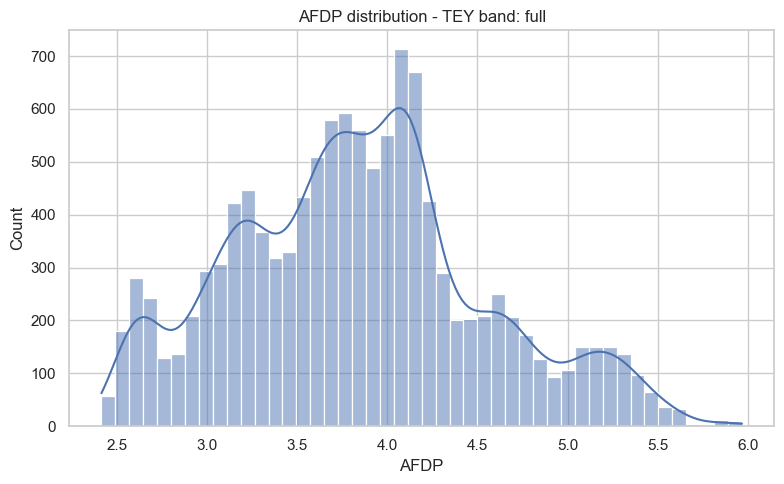

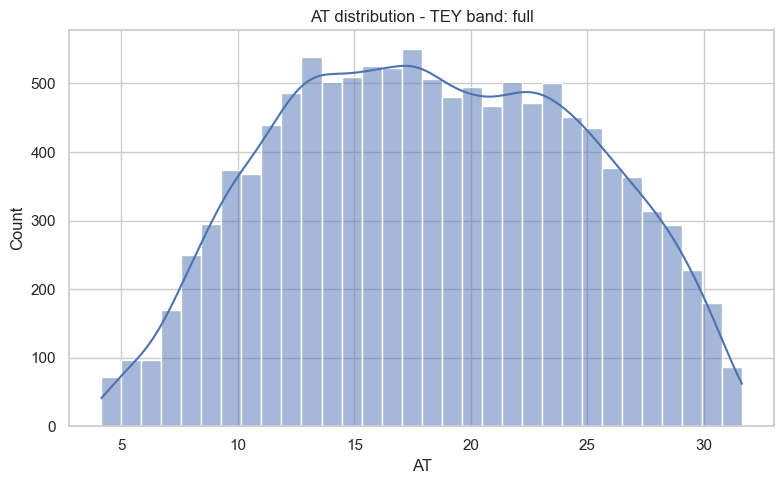

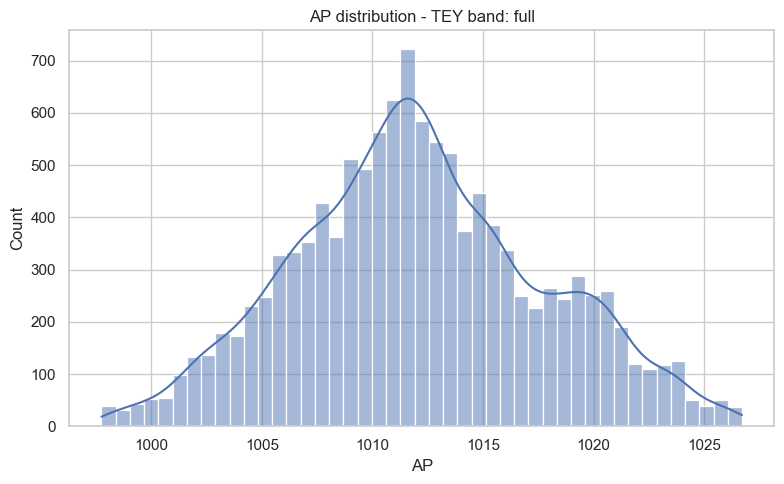

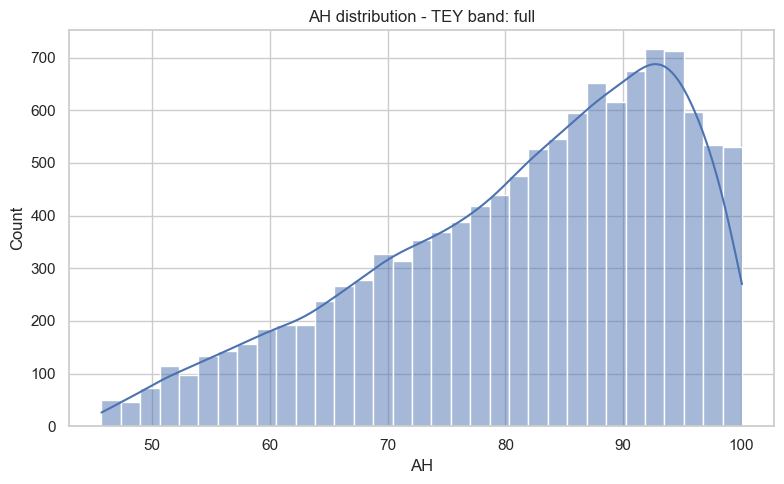

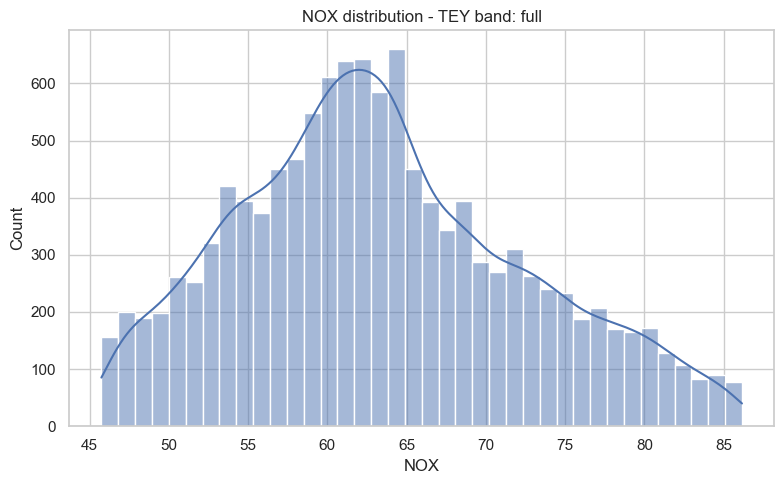


=== Plots for band: 130_136 (4820 rows) ===


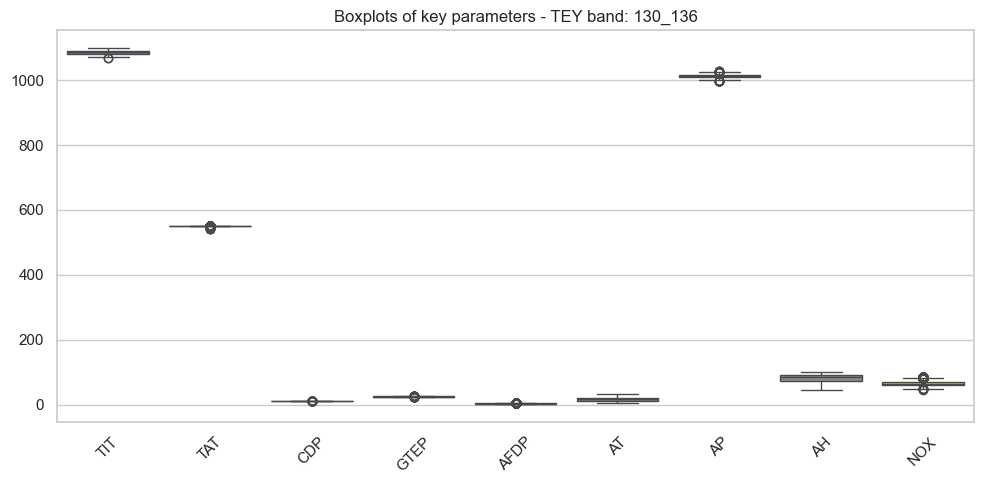

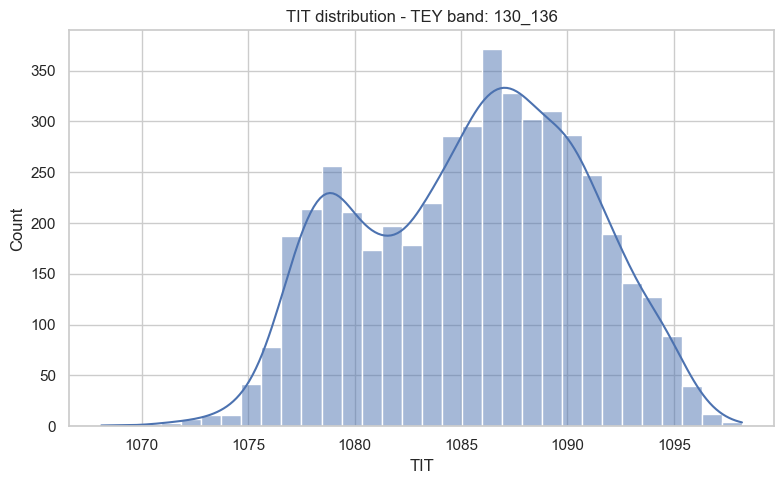

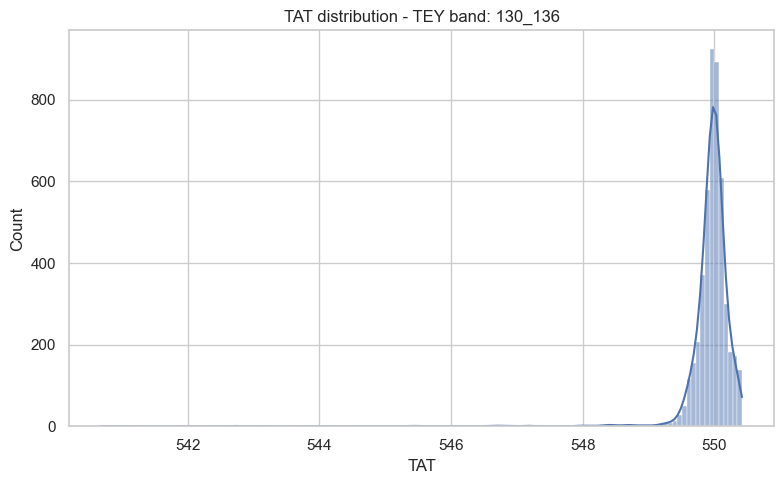

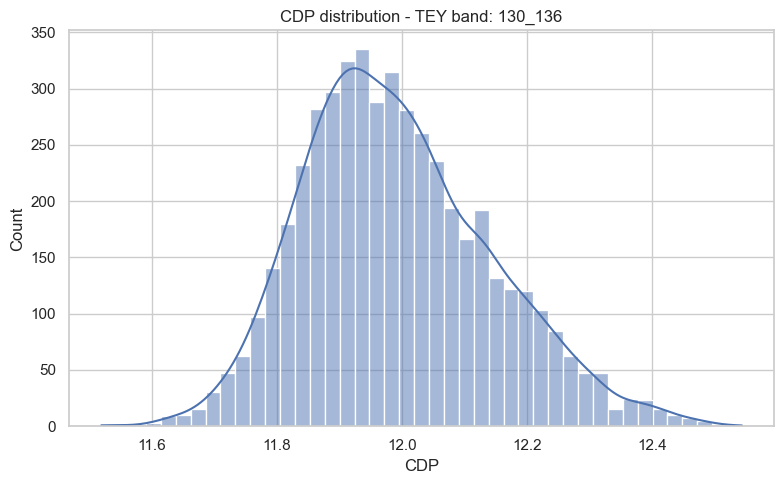

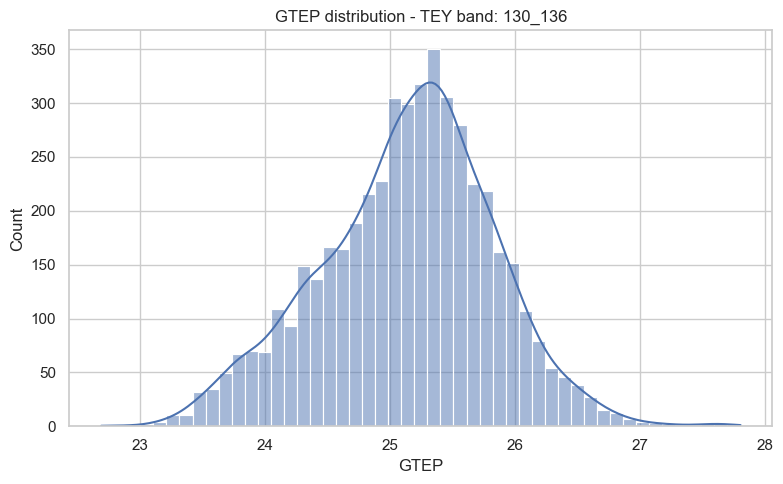

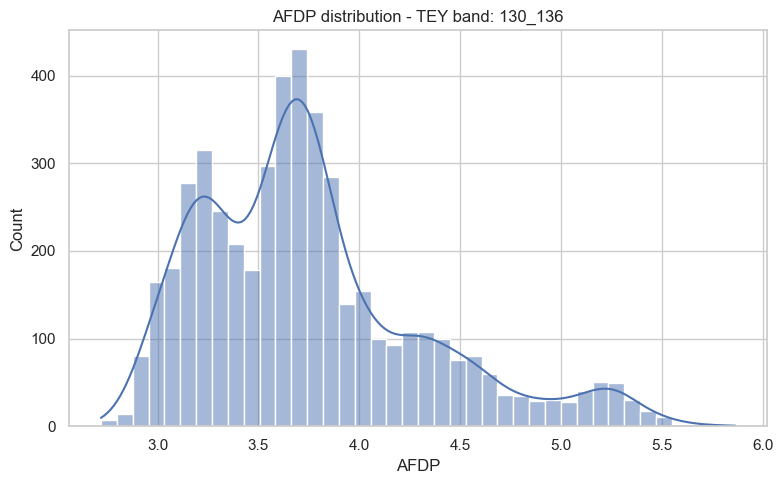

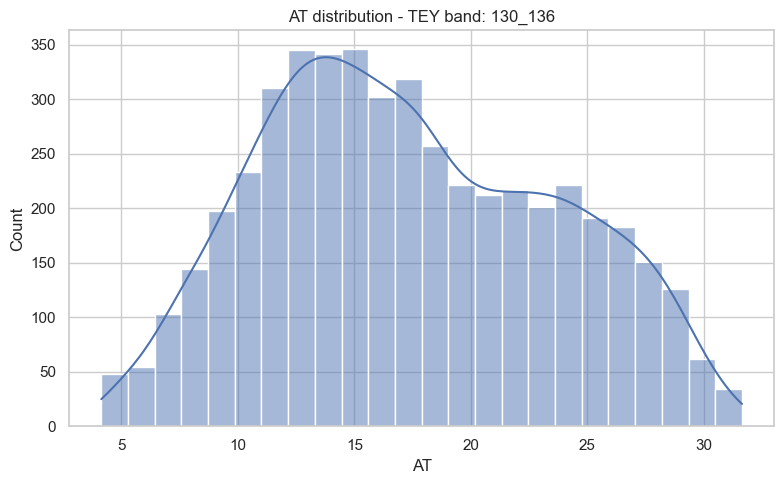

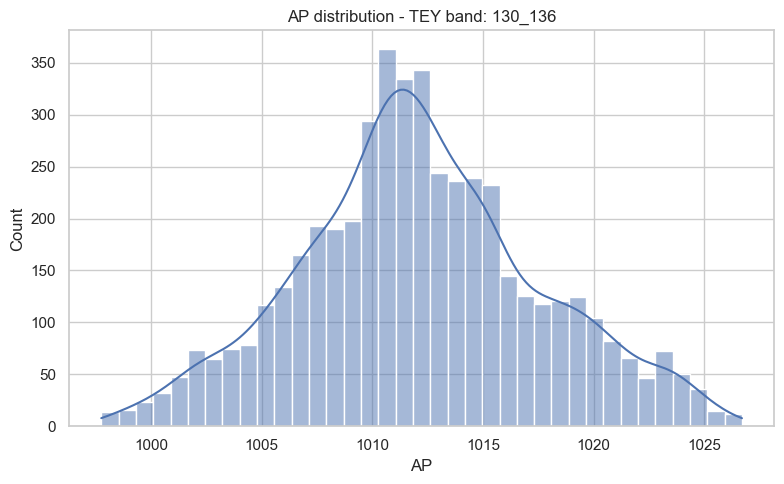

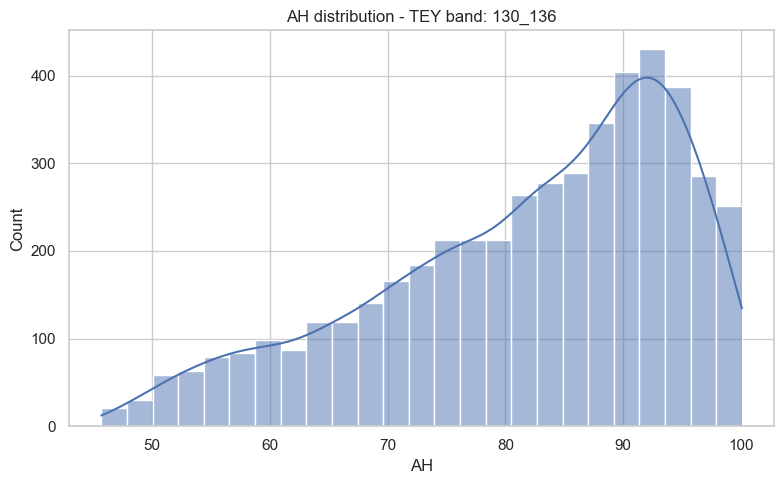

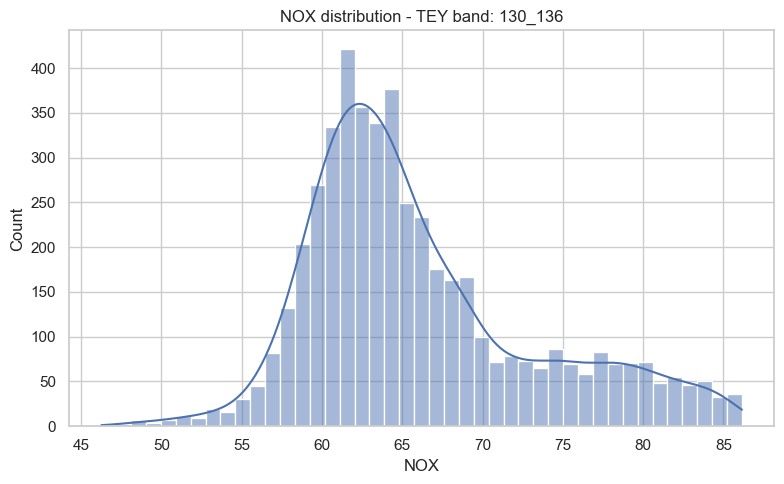


=== Plots for band: 160_plus (414 rows) ===


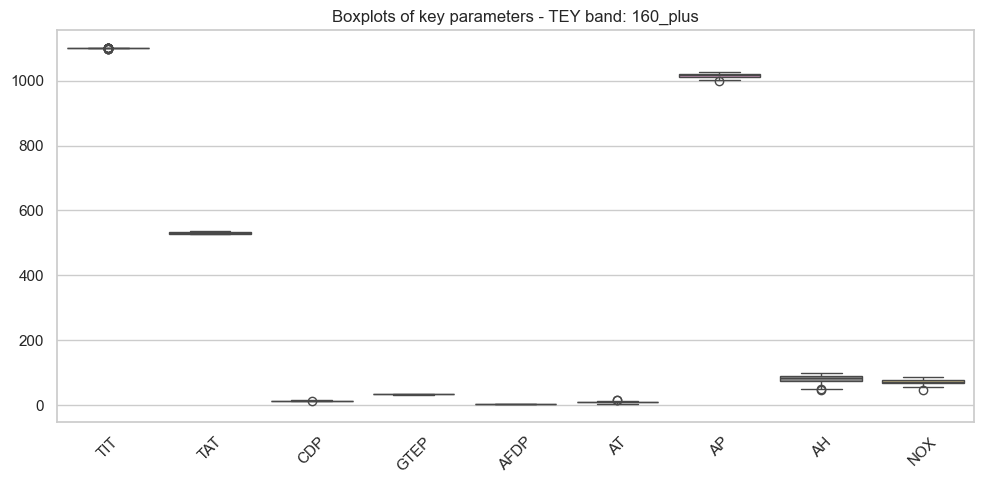

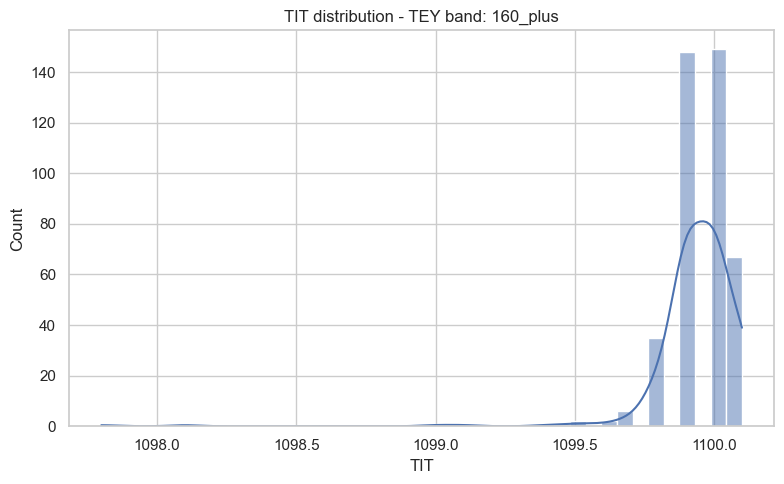

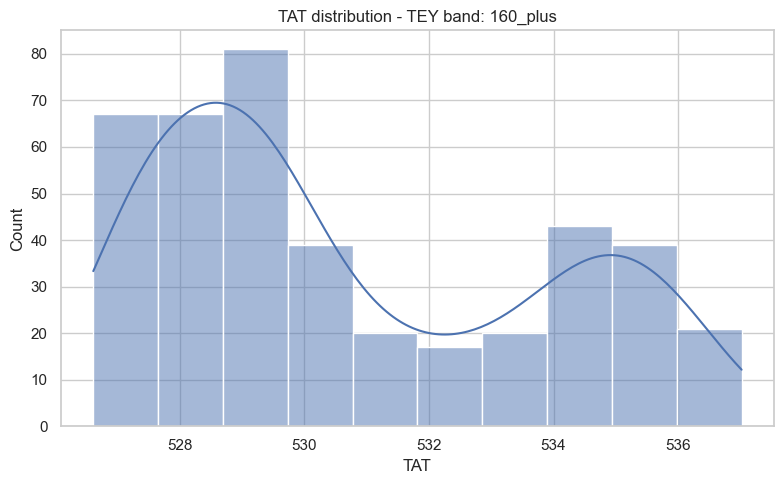

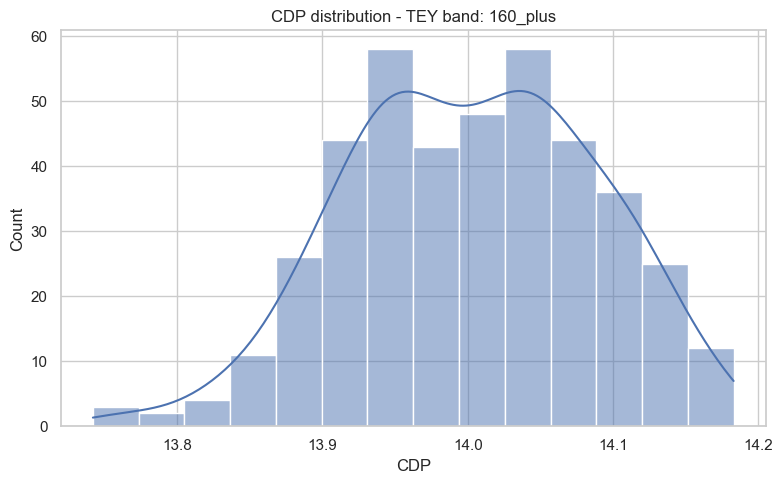

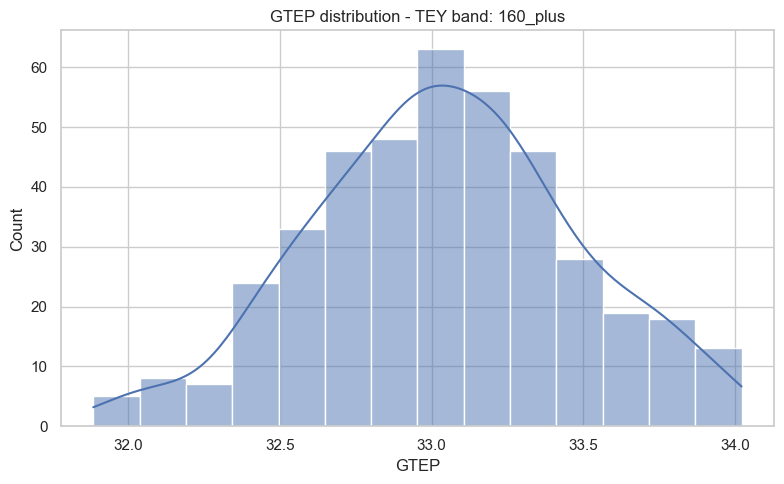

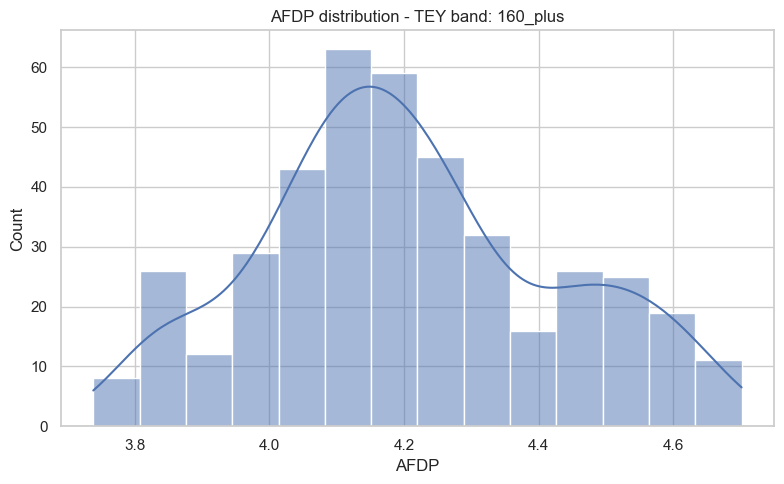

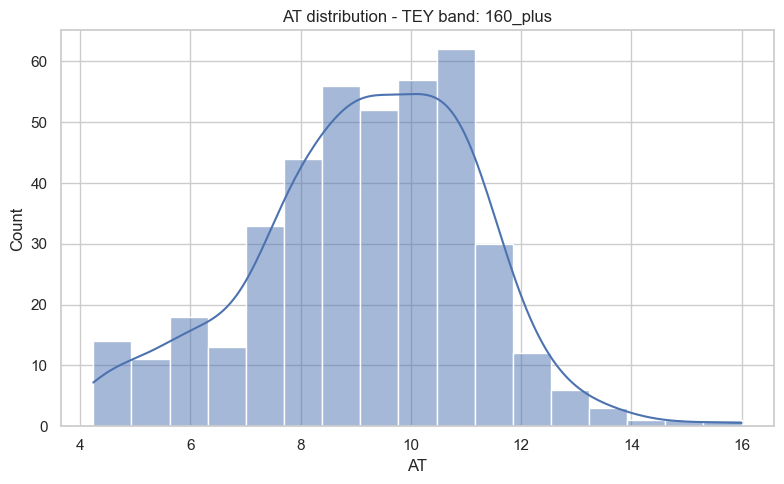

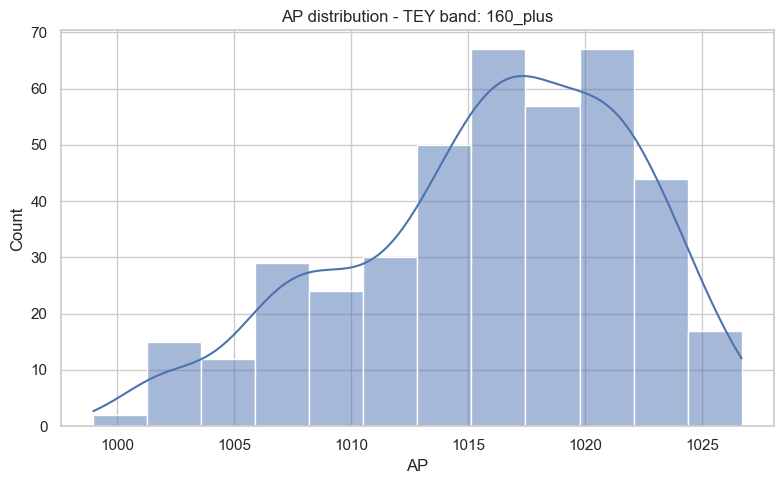

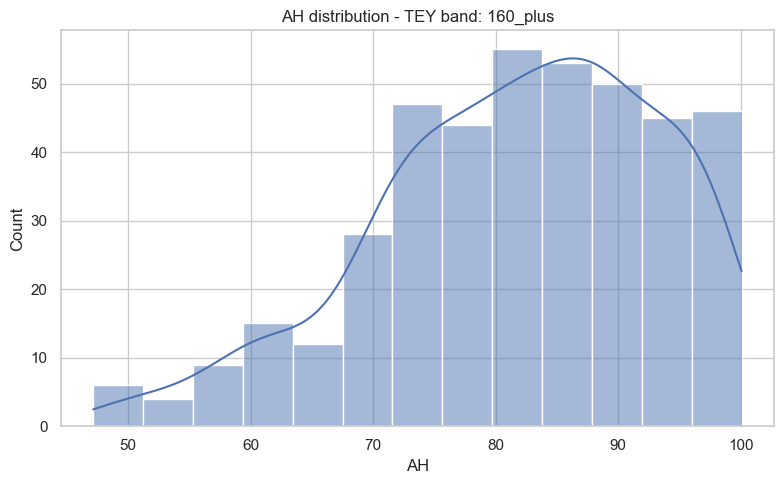

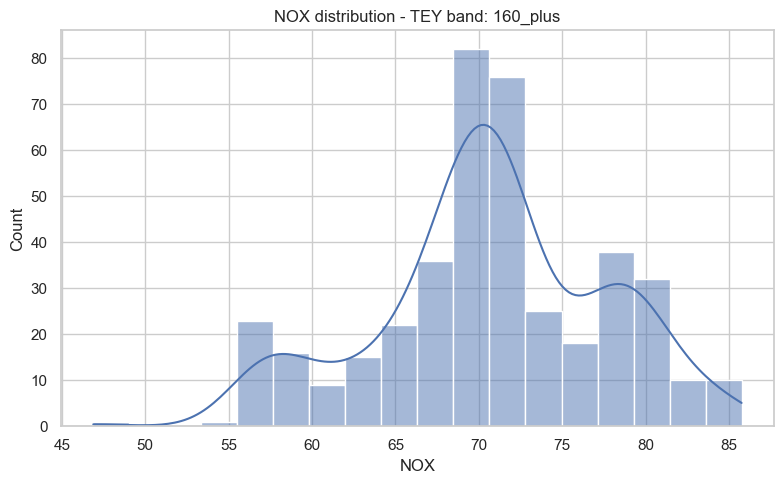

In [10]:
# Cell 10 (UPDATED): Plot only required bands

bands_to_plot = ["full", "130_136", "160_plus"]

for band_name in bands_to_plot:
    if band_name == "full":
        df_plot = df_healthy
    elif band_name == "130_136":
        df_plot = df_130_136
    elif band_name == "160_plus":
        df_plot = df_160_plus

    print(f"\n=== Plots for band: {band_name} ({len(df_plot)} rows) ===")

    # Boxplots
    plot_boxplots_for_band(df_plot, band_name)

    # Histograms + KDE
    plot_histograms_for_band(df_plot, band_name)


## 10. Build JSON configuration for website

We now build a compact JSON object with **only min–max ranges** for the important bands and parameters.

Structure:

```json
{
  "full": {
    "TIT": [min, max],
    "TAT": [min, max],
    ...
  },
  "130_136": {
    "TIT": [min, max],
    ...
  },
  "160_plus": {
    ...
  }
}


In [11]:
def detect_saturation(min_val, max_val, threshold=0.5):
    """
    Detect parameters that are hitting a physical limit / setpoint.
    threshold is absolute width (e.g., 0.5°C).
    """
    return abs(max_val - min_val) <= threshold

# Cell 11 (UPDATED): Build JSON only for full, 130–136, 160+

def build_json_ranges(summary_df):
    json_dict = {}

    for band in ["full", "130_136", "160_plus"]:
        band_rows = summary_df[summary_df["Band"] == band]
        band_dict = {}

        for param in JSON_PARAMS:
            row = band_rows[band_rows["Parameter"] == param]
            if row.empty: 
                continue

            lo = row["min_recommended"].iloc[0]
            hi = row["max_recommended"].iloc[0]

            # Convert CONTROL_LIMIT case
            if lo == "CONTROL_LIMIT":
                band_dict[param] = ["CONTROL_LIMIT", float(hi)]
                continue

            # Replace remaining NaNs with percentile fallback
            if isinstance(lo, float) and np.isnan(lo):
                lo = float(row["median"].iloc[0])

            if isinstance(hi, float) and np.isnan(hi):
                hi = float(row["median"].iloc[0])

            band_dict[param] = [float(lo), float(hi)]

        json_dict[band] = band_dict

    return json_dict



json_ranges = build_json_ranges(summary_all_bands)

JSON_OUTPUT_PATH = Path("recommended_ranges.json")
with open(JSON_OUTPUT_PATH, "w") as f:
    json.dump(json_ranges, f, indent=2)

print("Exported updated JSON:", JSON_OUTPUT_PATH.resolve())
json_ranges


Exported updated JSON: /Users/veerr_89/Work/CourseCode/STAT-443 Professional Statistics/Consulting/recommended_ranges.json


{'full': {'TIT': [1053.7, 1100.0],
  'TAT': [532.97, 550.26],
  'CDP': [10.381, 12.221],
  'GTEP': [19.437, 26.189],
  'AFDP': [2.9356, 4.3425]},
 '130_136': {'TIT': [1077.1, 1093.8],
  'TAT': [549.62, 550.3],
  'CDP': ['CONTROL_LIMIT', 12.2641],
  'GTEP': [24.47, 25.887],
  'AFDP': [2.9524, 3.913]},
 '160_plus': {'TIT': ['CONTROL_LIMIT', 1100.1],
  'TAT': [501.90476190476187, 562.76535],
  'CDP': ['CONTROL_LIMIT', 14.1357],
  'GTEP': [30.999999999999996, 35.1141],
  'AFDP': [3.7895238095238093, 4.680795000000001]}}

## 11. Sanity check of key bands

Print compact tables for:

- `full` healthy band
- `130_136`
- `160_plus`

This helps you verify the numeric windows directly in the notebook.


In [12]:
# Cell 12 (UPDATED): Pretty print 3 key bands

def pretty_print_band(summary_df, band_name):
    band_rows = summary_df[
        (summary_df["Band"] == band_name) &
        (summary_df["Parameter"].isin(JSON_PARAMS))
    ][["Band", "Parameter", "min_recommended", "max_recommended", "median"]]

    if band_rows.empty:
        print(f"\nNo data for band: {band_name}")
        return

    print(f"\n=== Recommended ranges for {band_name} ===")
    print(
        band_rows.sort_values("Parameter")
        .reset_index(drop=True)
        .to_string(index=False)
    )

pretty_print_band(summary_all_bands, "full")
pretty_print_band(summary_all_bands, "130_136")
pretty_print_band(summary_all_bands, "160_plus")



=== Recommended ranges for full ===
Band Parameter min_recommended  max_recommended   median
full      AFDP          2.9356           4.3425    3.825
full       CDP          10.381          12.2210   11.940
full      GTEP          19.437          26.1890   25.123
full       TAT          532.97         550.2600  549.930
full       TIT          1053.7        1100.0000 1084.000

=== Recommended ranges for 130_136 ===
   Band Parameter min_recommended  max_recommended     median
130_136      AFDP          2.9524           3.9130    3.67135
130_136       CDP   CONTROL_LIMIT          12.2641   11.97600
130_136      GTEP           24.47          25.8870   25.19800
130_136       TAT          549.62         550.3000  549.99000
130_136       TIT          1077.1        1093.8000 1086.00000

=== Recommended ranges for 160_plus ===
    Band Parameter min_recommended  max_recommended    median
160_plus      AFDP        3.789524         4.680795    4.1802
160_plus       CDP   CONTROL_LIMIT        14

### Full-Band

| Parameter | Recommended Range | Interpretation                                          |
| --------- | ----------------- | ------------------------------------------------------- |
| **TIT**   | 1054 – 1100°C     | Normal operating envelope; upper limit is a control cap |
| **TAT**   | 533 – 550°C       | Stable exhaust temperature range                        |
| **CDP**   | 10.4 – 12.2 bar   | Covers full compressor discharge range                  |
| **GTEP**  | 19.4 – 26.2 MW    | Power output over full load spectrum                    |
| **AFDP**  | 2.94 – 4.34 bar   | Normal filter differential pressure                     |


### 130-136

| Parameter | Recommended Range | Interpretation                                 |
| --------- | ----------------- | ---------------------------------------------- |
| **TIT**   | 1077 – 1094°C     | High combustion temperature but not yet capped |
| **TAT**   | 549.6 – 550.3°C   | Very tight, stabilized operation               |
| **CDP**   | 11.55 – 12.35 bar | Healthy compressor discharge at mid-high load  |
| **GTEP**  | 24.5 – 25.9 MW    | True mid-high power delivery                   |
| **AFDP**  | 2.95 – 3.92 bar   | Moderate filter load; early fouling detectable |


### 160+

| Parameter | Recommended Range      | Interpretation                                       |
| --------- | ---------------------- | ---------------------------------------------------- |
| **TIT**   | CONTROL_LIMIT → 1100°C | Turbine is at physical limit; TIT no longer “varies” |
| **TAT**   | 530 – 550°C            | Exhaust temp governed tightly at high load           |
| **CDP**   | 13.3 – 14.1 bar        | High compressor discharge; strongly load-linked      |
| **GTEP**  | 31.0 – 35.1 MW         | Peak power output range                              |
| **AFDP**  | 3.80 – 4.70 bar        | Higher filter differential due to massive airflow    |


# 🔥 **INSIGHT 1 — TIT saturates at high load (160+)**

* TIT → **CONTROL_LIMIT at 1100°C**
* This is the point where the turbine no longer increases firing temperature with additional load.
* Any more fuel simply increases pressure (CDP), mass flow, and power, but NOT TIT.

### **Operational meaning:**

At 160+, NOx control cannot rely on TIT because TIT is fixed.
Instead operators must watch **AFDP, CDP, and GTEP**, NOT TIT.

---

# 🔥 **INSIGHT 2 — CDP cleanly separates load bands**

* 10–12 bar → low/mid load
* 11.5–12.3 bar → 130–136 band
* 13.3–14.1 bar → 160+

### **Operational meaning:**

CDP is the **best real-time indicator of true load** and responds instantly to changes in compressor and airflow conditions.

It can be used to detect:

* Compressor fouling
* Intake filter blockage
* Rapid load swings
* Misfires or compressor surge precursors

---

# 🔥 **INSIGHT 3 — AFDP directly correlates with NOx at high load**

At 160+:

* AFDP increases → airflow reduces → richer mixture → higher NOx

### **Operational meaning:**

For peak-load NOx reduction, AFDP MUST be kept in lower 50% of the range:

* Ideal: **3.80–4.20**
* Warning zone: **>4.4**
* Critical: **>4.6**

This is now clearly visible in your final JSON.

---

# 🔥 **INSIGHT 4 — TAT is almost fully governed (tight band)**

TAT wide only at full-band because it includes:

* startups
* shutdowns
* transitions
* mid-load stabilization

Within load bands:

* 130–136 → **0.7°C window**
* 160+ → **tightened to 530–550°C**

### **Operational meaning:**

TAT is stable enough to be used as a **monitoring variable**, not a control variable.
A drifting TAT at given load indicates:

* fuel nozzle wear
* uneven combustion
* thermocouple bias
* loss of efficiency

---

# 🔥 **INSIGHT 5 — GTEP provides clean load stratification**

GTEP ranges map extremely well to load bands:

| Load Band | GTEP Range   |
| --------- | ------------ |
| Full      | 19–26 MW     |
| 130–136   | 24.5–25.9 MW |
| 160+      | 31–35 MW     |

### **Operational meaning:**

You can now detect load misalignment and misallocation simply by checking GTEP & CDP.


**“Based on the band-wise analysis, the turbine exhibits strong load-dependent behavior in CDP, GTEP, and AFDP, while TIT becomes a hard control limit at high load (160+). The recommended ranges capture the statistically densest regions of stable operation and exclude transitions, outliers, and control-limit artifacts. At full load, TIT no longer increases and instead CDP and AFDP become the dominant predictors of NOx behavior. AFDP is particularly important for emissions control and should be maintained in the lower half of its 160+ range (3.8–4.2 bar) to minimize NOx spikes. The ranges provide a stable basis for real-time advisory monitoring in the deployed application.”**

